<div style="text-align: center; font-size: 40px;">
    <b>Final Project</b>
    <br>
    Exploration of the Computer dataset
    <br>
    
</div>

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

Let's test our library code on the `computer` dataset from the UCR classification dataset available here : 
- https://www.timeseriesclassification.com/description.php?Dataset=Computers    

And we will need these helper function for visualization.

In [35]:
def plot_distribution(train_proba, test_proba): 
    fig, ax = plt.subplots()
    ax.hist(train_proba, bins=20, label="baseline", alpha=0.7, density=True)
    ax.hist(test_proba, bins=20,  label="anomaly", alpha=0.7, density=True)
    ax.set_title('Distribution of probility score, train and test set')
    ax.set_xlabel("score")
    ax.legend()
    plt.show()

def plot_proba_distribution(validation_proba, test_proba, ax, k): 
    ax.hist(validation_proba, bins=20, label="baseline", alpha=0.7, density=True)
    ax.hist(test_proba, bins=20,  label="anomaly", alpha=0.7, density=True)
    ax.set_title(f'Knearest : {k}, anomaly score')
    ax.set_xlabel("score")
    ax.legend()

def plot_AUC_score(validation_proba, test_proba, ax, k): 
    proba = validation_proba
    labels = test_proba
    # proba = list(validation_proba) + list(test_proba)
    # labels = [1 for _ in range(len(validation_proba))] + [0 for _ in range(len(test_proba))]
    auc_score = roc_auc_score(labels, proba)
    fpr, tpr, thresholds = roc_curve(labels, proba)

    ax.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'K_nearest : {k}, ROC curve')
    ax.legend(loc='lower right')
    ax.grid()

# I) A first look at our data

## SAX Transformation

Since the data is actually a dataset of continuous sequences, we will need transform it into a discreet sequence using the SAX method. Thankfully, we implemented a `SAX`class in opur library, that given an `.arff` file, transform it into a labelised dataset of discreet sequences. There are two modes to this class, `local` and `global`, where `global`utilizes the values from the whole dataset of timeseries to assign the breakpoints for the sax method, whereas `local` only compute these values on the timeserie that is being transformed into a sylmbolic serie.

In [5]:
from utils import SAX, DataInspector
import os
import pandas as pd


In [11]:

# filename = "../Data/DodgerLoopGame/dataset.pkl"

# saxer = SAX(word_size=5, alphabet_size=5, mode="local")
# continuous_timeseries = saxer.ingest_pickle(filename)
# dataset = saxer.transform()

folder_path = "../Data/TSB_UAD/TSB-UAD-Public/Dodgers"


sax = SAX(word_size=10, alphabet_size=7, mode="local")  # Set SAX parameters
df_clean = sax.read_file(os.path.join(folder_path, "101-freeway-traffic.test.out"))
print(f"Data loaded with {len(df_clean)} points.")

Data loaded with 47497 points.


In [12]:
dataset = sax.transform_with_sliding_windows(window_size=200, stride=100)
dataset.head()

C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,sequence,timeserie,label
0,"[F, F, E, E, D, D, C, D, F, G, F, F, E, E, C, ...","[23, 42, 37, 24, 39, 25, 33, 34, 33, 34, 29, 3...",0
1,"[G, G, F, F, E, D, D, C, C, B, B, B, A, A, A, ...","[38, 48, 29, 33, 40, 38, 29, 36, 42, 25, 28, 3...",0
2,"[A, A, A, A, A, A, B, D, F, F, F, F, D, D, F, ...","[6, 1, 4, 9, 4, 6, 13, 5, 5, 4, 7, 5, 4, 5, 1,...",1
3,"[F, E, C, C, E, E, E, E, G, G, F, F, F, D, B, ...","[41, 37, 36, 40, 37, 41, 38, 36, 44, 33, 30, 4...",1
4,"[G, G, G, E, D, D, C, B, B, B, B, A, A, B, B, ...","[40, 33, 46, 44, 39, 49, 41, 31, 40, 44, 33, 4...",0


You can visualize a few of the sequences here, by adjusting the paramter of the `display_sequence` function.

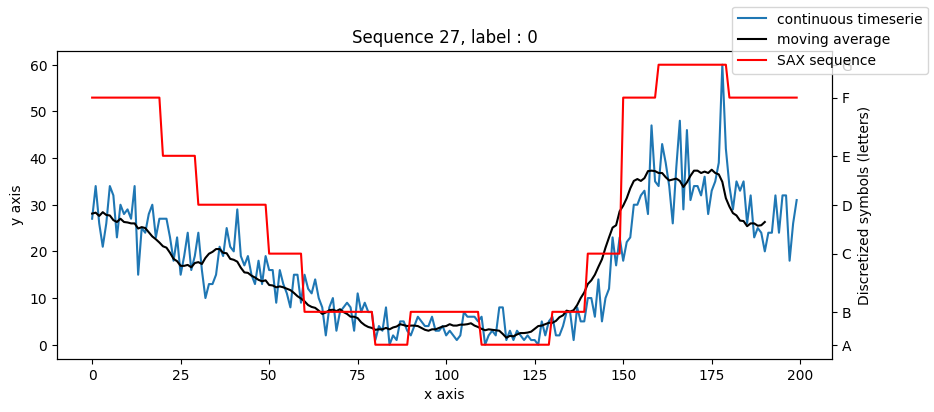

In [14]:
sax.display_sequence(27, display_moving_average=True)

## How did SAX transform the underlying data ? 

In this section, we examine how the SAX transformation impacted the separability of the two classes in the original dataset and we try to understand a bit better how the information is contained in our data using PCA.

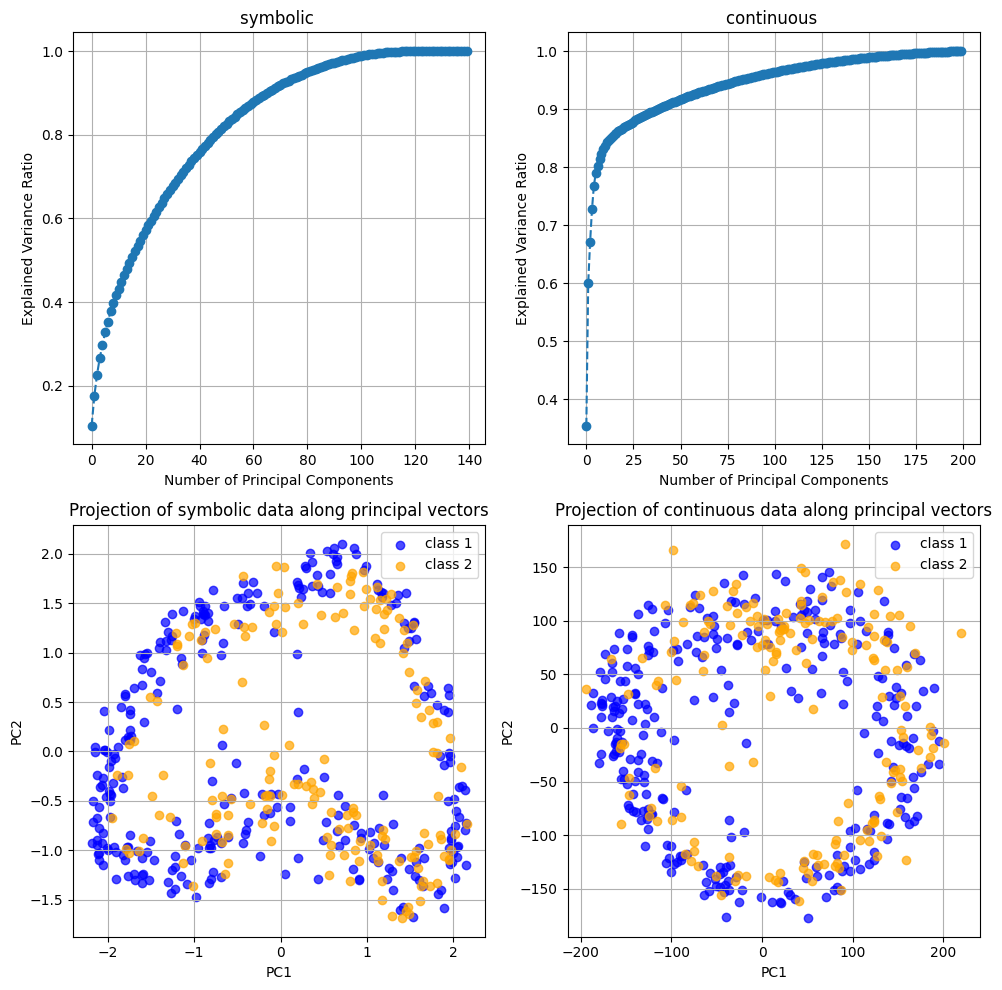

In [16]:
data_inspector = DataInspector(dataset)
data_inspector.display_pca(figsize=(10, 10))

## Separability Test :

One of the main problems we faced when using our models for anomaly detection, is how different the two classes of the continuous signal were to each other. So to first understand our data better, we will check how well different models are able to separate the data. The two below methods compute the AUC score of a SVM trained on the dataset of continuous series versus the dataset of symbolic series.

In [17]:
data_inspector.continuous_separability(C=10)

np.float64(0.876172607879925)

In [18]:
data_inspector.symbolic_separability(C=1)

np.float64(0.717010631644778)

Let us plot the AUC curve

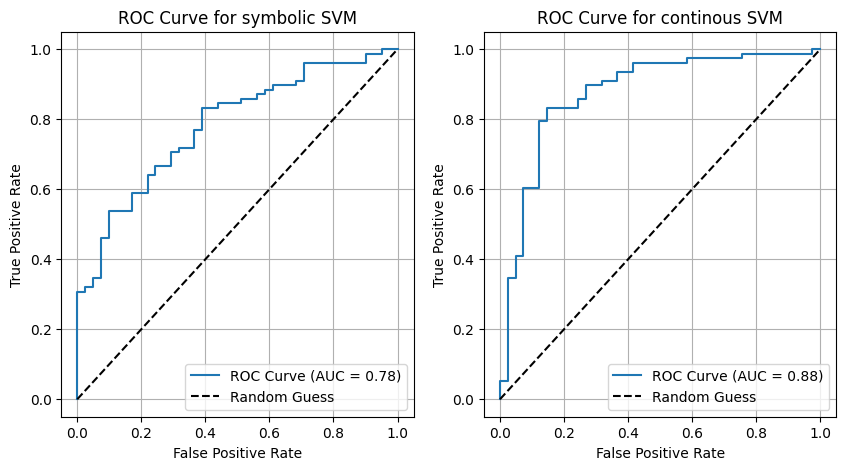

In [19]:
data_inspector.display_AUC_score(figsize=(10, 5))

From the above inspection, our data seems very separable using a classical SVM on the SAX-transformed data. Our method should at least achieve satisfactory results. **However, let us remember that the classification problem, when one knows the category of the anomaly, is an easier problem than to infer anomalies from just one baseline class as was suggested in the article**.

### (A parte) And what about dimensionality reduction techniques ?

Here we just plotted the reduced dimensionality data to see how well the SVM could perform with reduced dimensionality data.

C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


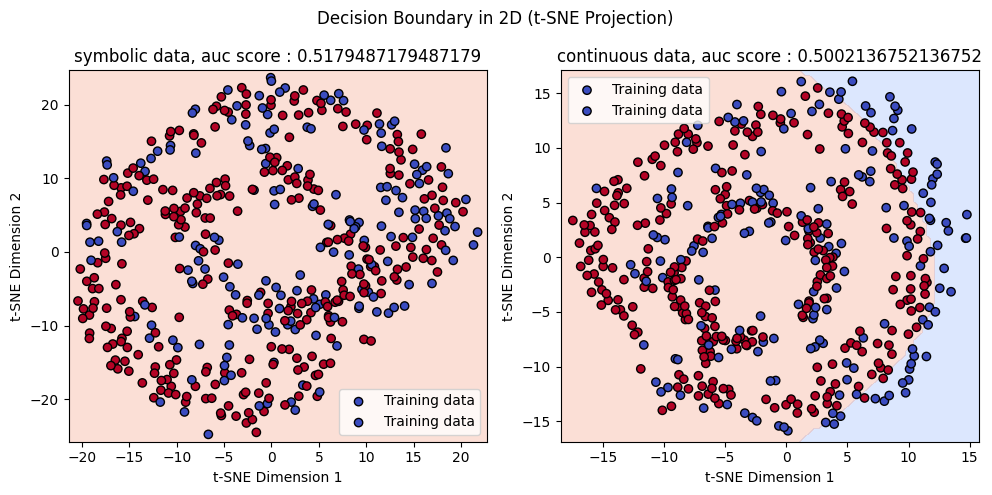

In [20]:
data_inspector.display_decision_boundary_t_SNE()

Here we see that the SAX method performs very poorly once dimensionality is reducted, while t-SNE still manages to keep most of the underlying information when data is continuous. And we already somewhat intuited that by looking at the PCA plots which showed more variance was exmplained by the two first eigenvectors in the continous case compared to the symbolic one.

# Benchmarking our Library on Real Data : The experiment 

In the following section, we will test all the techniques implemented in our library against the SAX transformed dataset you saw earlier.     

It is important to note that these methods rely on the training set being a set of "good" sequence, ie they serve as the baseline of what is considered normal. The anomalous data is not "seen" at training time, as it was suggested in section IV of the article. **This is a feature, not a bug**. This is why the anomaly detection problem is considerably harder than a classification one.    

This is why we split the dataset of the first part of the notebook in three. The "baseline" or "good" data is selected as one of the two class in the dataset. This selected class is then split into a training and a validation set. The second class in the original dataset is then considered as the anomaly class. 

Now let us parse the dataset into a baseline set, an anomalous set, and let's create baseline validation set to see the anomaly score assigned to baseline data.

In [21]:
baseline = dataset.loc[dataset["label"] == 0]
anomaly = dataset.loc[dataset["label"] == 1]

print(f"length category 1 : {len(anomaly)} : length category 2 : {len(baseline)}")

baseline_train = baseline.sample(frac=0.8, random_state=42)
baseline_validation = baseline.drop(baseline_train.index)
test_set = pd.concat([baseline_validation, anomaly])

anomaly_sample = anomaly.sample(frac=0.8, random_state=42)

baseline_validation = baseline_validation["sequence"].values
baseline_train = baseline_train["sequence"].values
anomaly_sample = anomaly_sample["sequence"].values

test_labels = test_set['label'].values
test_set = test_set["sequence"].values

length category 1 : 173 : length category 2 : 300


# I) Kernel Based Techniques :

The Kernel based techniques all rely on... well a kernel, which is a function that given two sequence returns a metric of how similar they are to each other. In the article, we noted two ways of detecting anomalies using kernel, one relying on a KNearest algorithm and one relying on Medoids. 

In [23]:
from KernelBased import nLCS

For this section, we will take the length of the longest common symbolic subsequence as the kernel between two sequences.

In [24]:
dataset.head()

,sequence,timeserie,label
0,"[F, F, E, E, D, D, C, D, F, G, F, F, E, E, C, ...","[23, 42, 37, 24, 39, 25, 33, 34, 33, 34, 29, 3...",0
1,"[G, G, F, F, E, D, D, C, C, B, B, B, A, A, A, ...","[38, 48, 29, 33, 40, 38, 29, 36, 42, 25, 28, 3...",0
2,"[A, A, A, A, A, A, B, D, F, F, F, F, D, D, F, ...","[6, 1, 4, 9, 4, 6, 13, 5, 5, 4, 7, 5, 4, 5, 1,...",1
3,"[F, E, C, C, E, E, E, E, G, G, F, F, F, D, B, ...","[41, 37, 36, 40, 37, 41, 38, 36, 44, 33, 30, 4...",1
4,"[G, G, G, E, D, D, C, B, B, B, B, A, A, B, B, ...","[40, 33, 46, 44, 39, 49, 41, 31, 40, 44, 33, 4...",0


### KNearest : 

The training phase of a Knearest Kernel method is simply loading the dataset. To compute the anomaly score of a new serie, we will compute the kernel score of that sample against all the serie of our dataset, take the K-th smallest score and return the anomaly score as the inverse of that score. The training is therefore simply loading the dataset. Let's see it ! 

In [43]:
from KernelBased import KnearestKernel

knearest_dad = KnearestKernel(nLCS, k_nearest=5)
knearest_dad.train(baseline_train)

validation_proba_5 = knearest_dad.predict_proba(baseline_validation)
test_proba_5 = knearest_dad.predict_proba(anomaly_sample)

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve(method, test_labels, test_proba):
    roc_auc = roc_auc_score(test_labels, test_proba)
    fpr, tpr, _ = roc_curve(test_labels, test_proba)
    plt.plot(fpr, tpr, label=f"{method}" + " (AUC = {:.2f})".format(roc_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


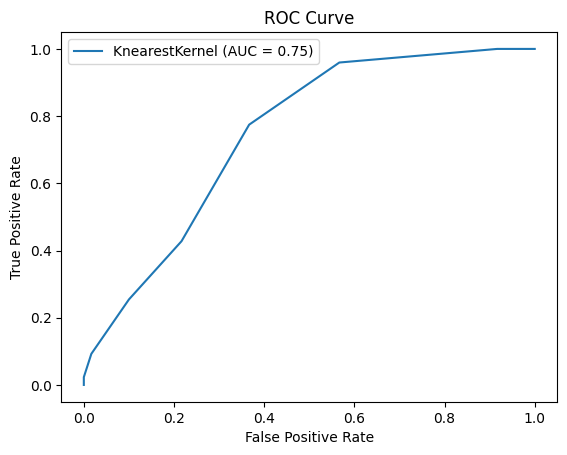

In [45]:
test_proba = knearest_dad.predict_proba(test_set)

plot_roc_curve("KnearestKernel", test_labels, test_proba)

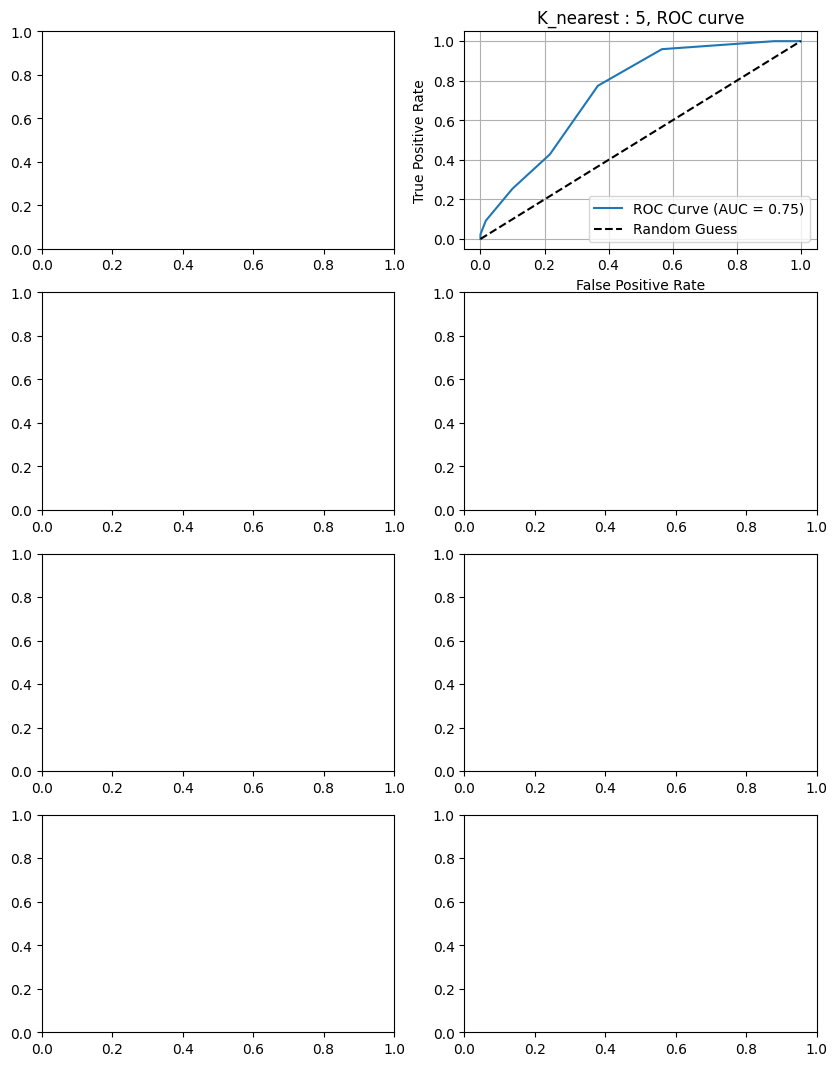

In [46]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
fig.set_figwidth(10)
fig.set_figheight(13)

plot_AUC_score(validation_proba=test_proba, test_proba=test_labels, ax=ax2, k=5)

Now let us try this method for different value of K (the nearest sequence to compute anomaly score on) and evaluate the impact of K on the distribution of anomaly socre on the test and validation set.

In [28]:
# knearest_dad.set_knearest(1)
# validation_proba_1 = knearest_dad.predict_proba(baseline_validation)
# test_proba_1 = knearest_dad.predict_proba(anomaly_sample)
# knearest_dad.set_knearest(3)
# validation_proba_3 = knearest_dad.predict_proba(baseline_validation)
# test_proba_3 = knearest_dad.predict_proba(anomaly_sample)
# knearest_dad.set_knearest(7)
# validation_proba_7 = knearest_dad.predict_proba(baseline_validation)
# test_proba_7 = knearest_dad.predict_proba(anomaly_sample)
# knearest_dad.set_knearest(15)
# validation_proba_15 = knearest_dad.predict_proba(baseline_validation)
# test_proba_15 = knearest_dad.predict_proba(anomaly_sample)
# knearest_dad.set_knearest(30)
# validation_proba_30 = knearest_dad.predict_proba(baseline_validation)
# test_proba_30 = knearest_dad.predict_proba(anomaly_sample)
# knearest_dad.set_knearest(100)
# validation_proba_100= knearest_dad.predict_proba(baseline_validation)
# test_proba_100 = knearest_dad.predict_proba(anomaly_sample)
# knearest_dad.set_knearest(-10)
# validation_proba_minus_10 = knearest_dad.predict_proba(baseline_validation)
# test_proba_minus_10 = knearest_dad.predict_proba(anomaly_sample)

Mouad testing

In [47]:
knearest_dad.set_knearest(1)
test_proba_1 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(3)
test_proba_3 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(7)
test_proba_7 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(15)
test_proba_15 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(30)
test_proba_30 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(100)
test_proba_100 = knearest_dad.predict_proba(test_set=test_set)
knearest_dad.set_knearest(-10)
test_proba_minus_10 = knearest_dad.predict_proba(test_set=test_set)

In [49]:
plot_AUC_score(test_proba_5, test_labels, ax3, 5)

ValueError: Found input variables with inconsistent numbers of samples: [233, 138]

ValueError: Found input variables with inconsistent numbers of samples: [233, 138]

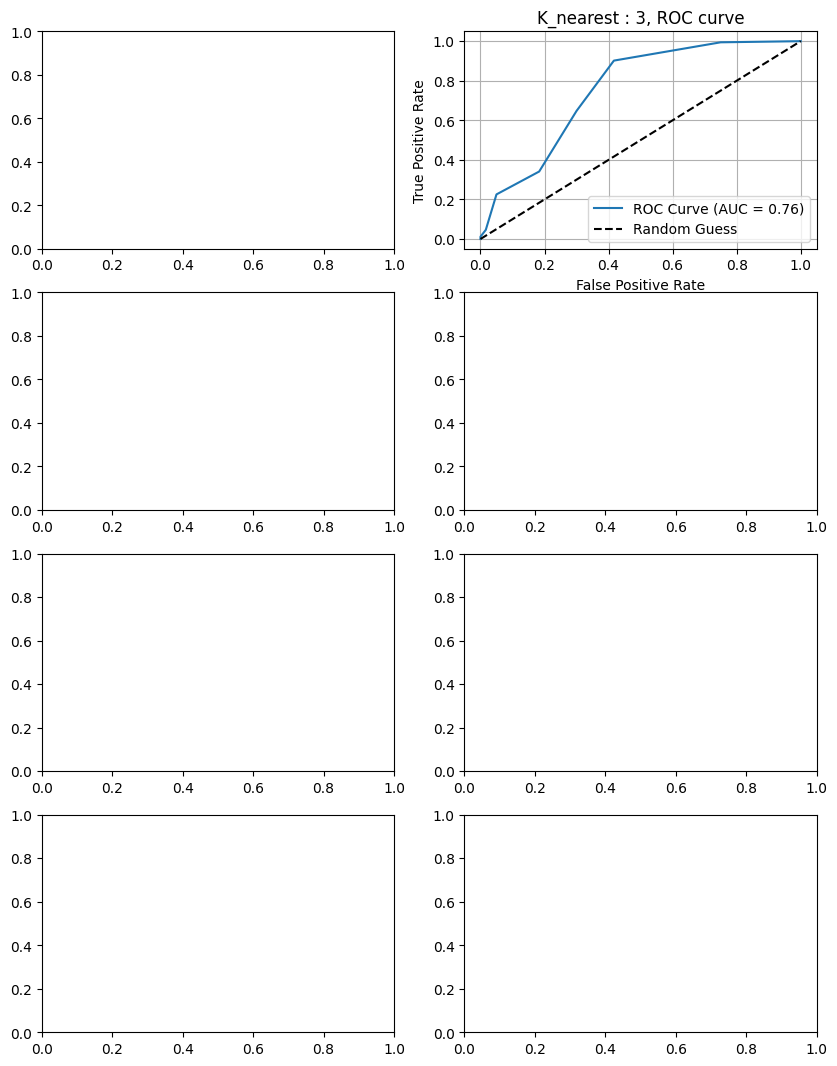

In [48]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
fig.set_figwidth(10)
fig.set_figheight(13)

plot_AUC_score(test_proba_3, test_labels, ax2, 3)
plot_AUC_score(test_proba_5, test_labels, ax3, 5)
plot_AUC_score(test_proba_7, test_labels, ax4, 7)
# plot_proba_distribution(validation_proba_15, test_proba_15, ax5, 20)
# plot_proba_distribution(validation_proba_30, test_proba_30, ax6, 30)
# plot_proba_distribution(validation_proba_100, test_proba_100, ax7, 100)
# plot_proba_distribution(validation_proba_minus_10, test_proba_minus_10, ax8,-10)
fig.tight_layout()


Not let us plot the distribution and the ROC curve to see how this model did. We plotted the ROC curve for the first values of k, and then the distribution of anomaly score for the validation and test set. Both metric (superposition of distribution of anomaly score for test and validation) as well as poor ROC curve tells us that this kernel did very, very poorly.

ValueError: Found input variables with inconsistent numbers of samples: [233, 60]

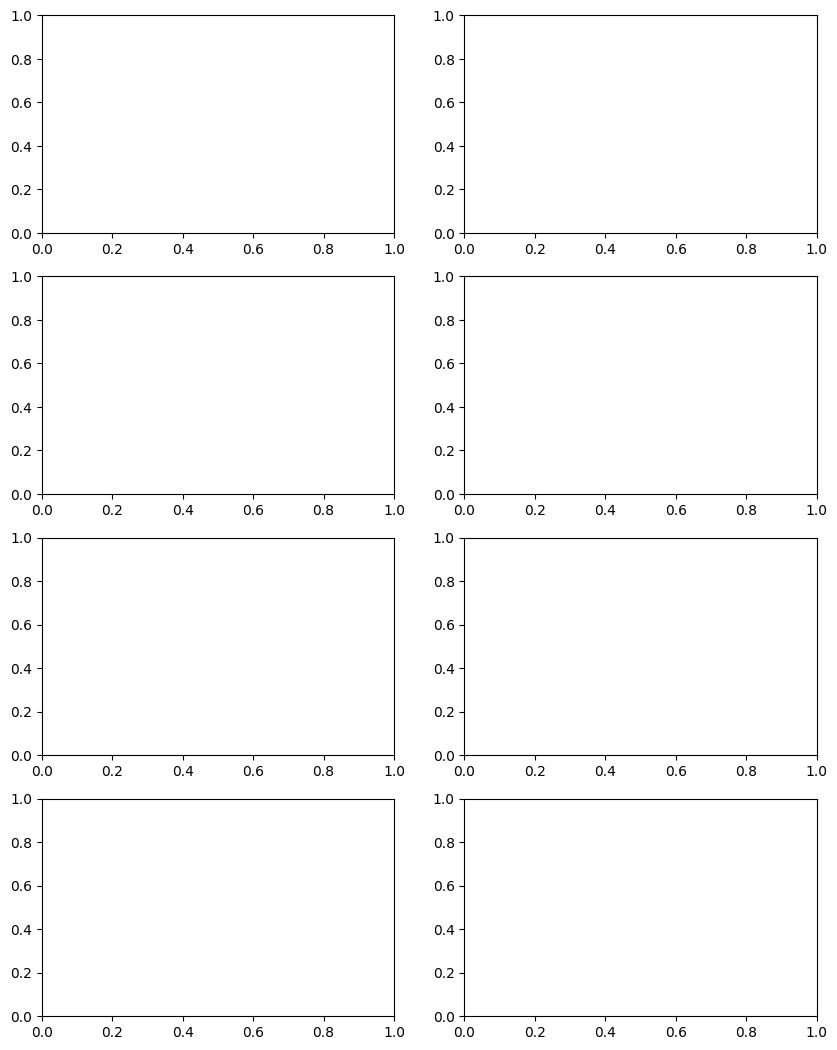

In [39]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
fig.set_figwidth(10)
fig.set_figheight(13)

plot_AUC_score(validation_proba_3, test_labels, ax2, 3)
plot_AUC_score(validation_proba_5, test_labels, ax3, 5)
plot_AUC_score(validation_proba_7, test_labels, ax4, 7)
# plot_proba_distribution(validation_proba_15, test_proba_15, ax5, 20)
# plot_proba_distribution(validation_proba_30, test_proba_30, ax6, 30)
# plot_proba_distribution(validation_proba_100, test_proba_100, ax7, 100)
# plot_proba_distribution(validation_proba_minus_10, test_proba_minus_10, ax8,-10)
fig.tight_layout()


So we see that on this dataset, even very large value of k, which would indicate selecting for sequences that are most dissimilar to the test sample, does not provide good separation between our baseline and anomaly dataset. 

The results are pretty pathetic, as our algorithm performs worse than chance.

**We consider this method to have failed on our real dataset**

### KMedoids :

This method relies on computing a similarity matrix of all the sequence in our dataset at training time, and using this similarity matrix to find the Medoids in our dataset, ie the sequences that are most "like" the other sequences in our dataset. Once obtained, the anomaly score is assigned by giving the kernel distance between the sample data and the medoid that is closed to it. Let's see how it performs on real data ! 

In [16]:
from KernelBased import MedoidsKernel

kmedoids_dad = MedoidsKernel(nLCS)
kmedoids_dad.train(baseline_train)

train_proba = kmedoids_dad.predict_proba(baseline_validation)
test_proba = kmedoids_dad.predict_proba(anomaly_sample)
print(f"The optimal number of cluster found is : {len(kmedoids_dad.medoids)}")

The optimal number of cluster found is : 2


By default our class is implemented to find the optimal number of Medoids using the `kmedoids.dynmsc` method of the `kmedoids` library of python. However, let us evaluate the influence of the number of medoids of the distribution of the anomaly score on the baseline validation and test data.

In [17]:
kmedoids_dad.set_new_medoids(3)
train_proba_3 = kmedoids_dad.predict_proba(baseline_validation)
test_proba_3 = kmedoids_dad.predict_proba(anomaly_sample)
kmedoids_dad.set_new_medoids(5)
train_proba_5 = kmedoids_dad.predict_proba(baseline_validation)
test_proba_5 = kmedoids_dad.predict_proba(anomaly_sample)
kmedoids_dad.set_new_medoids(7)
train_proba_7 = kmedoids_dad.predict_proba(baseline_validation)
test_proba_7 = kmedoids_dad.predict_proba(anomaly_sample)
kmedoids_dad.set_new_medoids(10)
train_proba_10 = kmedoids_dad.predict_proba(baseline_validation)
test_proba_10 = kmedoids_dad.predict_proba(anomaly_sample)
kmedoids_dad.set_new_medoids(20)
train_proba_20 = kmedoids_dad.predict_proba(baseline_validation)
test_proba_20 = kmedoids_dad.predict_proba(anomaly_sample)

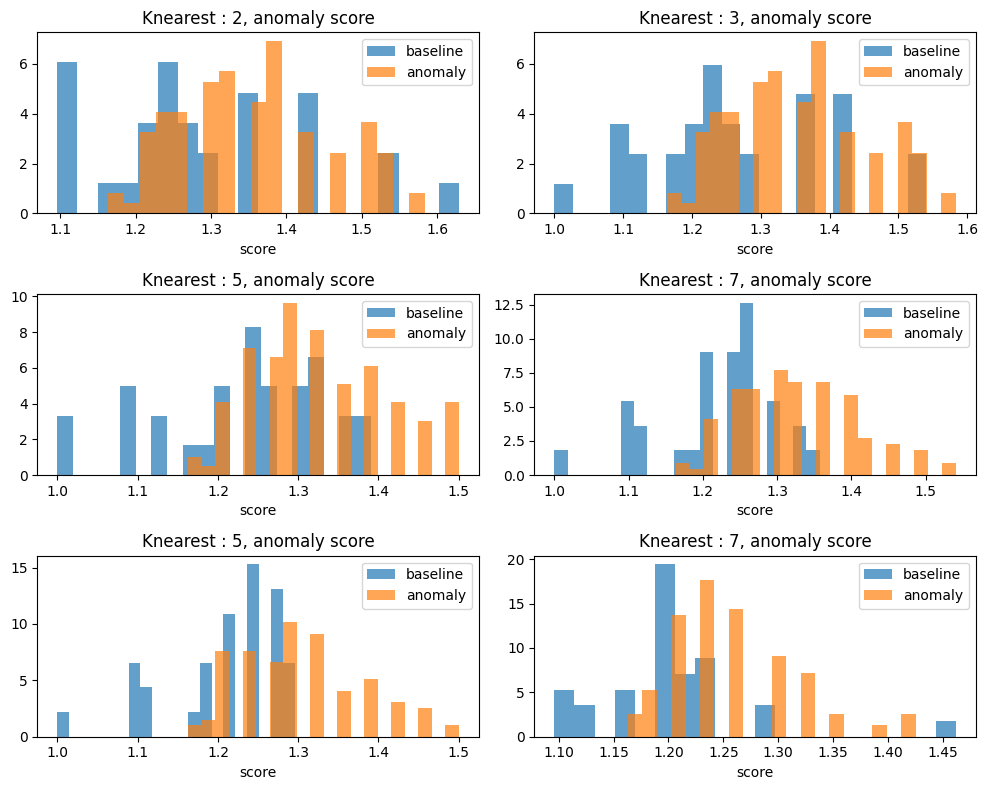

In [18]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(10)
fig.set_figheight(8)
plot_proba_distribution(train_proba, test_proba, ax1, 2)
plot_proba_distribution(train_proba_3, test_proba_3, ax2, 3)
plot_proba_distribution(train_proba_5, test_proba_5, ax3, 5)
plot_proba_distribution(train_proba_7, test_proba_7, ax4, 7)
plot_proba_distribution(train_proba_10, test_proba_10, ax5, 5)
plot_proba_distribution(train_proba_20, test_proba_20, ax6, 7)
fig.tight_layout()

There is no significant difference between the distribution of probability score for the anomalous set or the baseline set, therefore the kernel based method can not work on this dataset. This is especially clear since the distribution of the continuous sequences are also very similar to one another.

### Computation time : Kernel Methods : 

Knearest might be more interesting if the test sample during the lifetime of the algorithm is not larger than the training set, otherwise the Medoids based method quickly becomes more computationaly interesting, as the computation structure is split between a very high computation time at training (generating the similarity matrix) but an otherwise small computation time at testing, as we simply test against the medoids.

## Attempts on New Kernel :    

It is very clear that the above methods did not yield satisfying results. This is because our kernel, nLCS, is derived by taking the length of the longest common sequence between two sequences. Is not appropriate to our dataset, which can be very noisy. Let us switch to more robust kernels to examine the results. 

In [ ]:
from KernelBased import edit_distance_kernel, spectrum_kernel

In [20]:
distance_DAD = MedoidsKernel(edit_distance_kernel)
distance_DAD.train(baseline_train)

train_proba = distance_DAD.predict_proba(baseline_validation)
test_proba = distance_DAD.predict_proba(anomaly_sample)
print(f"The optimal number of cluster found is : {len(kmedoids_dad.medoids)}")

The optimal number of cluster found is : 20


In [22]:
distance_DAD.set_new_medoids(3)
train_proba_3 = distance_DAD.predict_proba(baseline_validation)
test_proba_3 = distance_DAD.predict_proba(anomaly_sample)
kmedoids_dad.set_new_medoids(5)
train_proba_5 = distance_DAD.predict_proba(baseline_validation)
test_proba_5 = distance_DAD.predict_proba(anomaly_sample)
kmedoids_dad.set_new_medoids(7)
train_proba_7 = distance_DAD.predict_proba(baseline_validation)
test_proba_7 = distance_DAD.predict_proba(anomaly_sample)
kmedoids_dad.set_new_medoids(10)
train_proba_10 = distance_DAD.predict_proba(baseline_validation)
test_proba_10 = distance_DAD.predict_proba(anomaly_sample)
kmedoids_dad.set_new_medoids(20)
train_proba_20 = distance_DAD.predict_proba(baseline_validation)
test_proba_20 = distance_DAD.predict_proba(anomaly_sample)

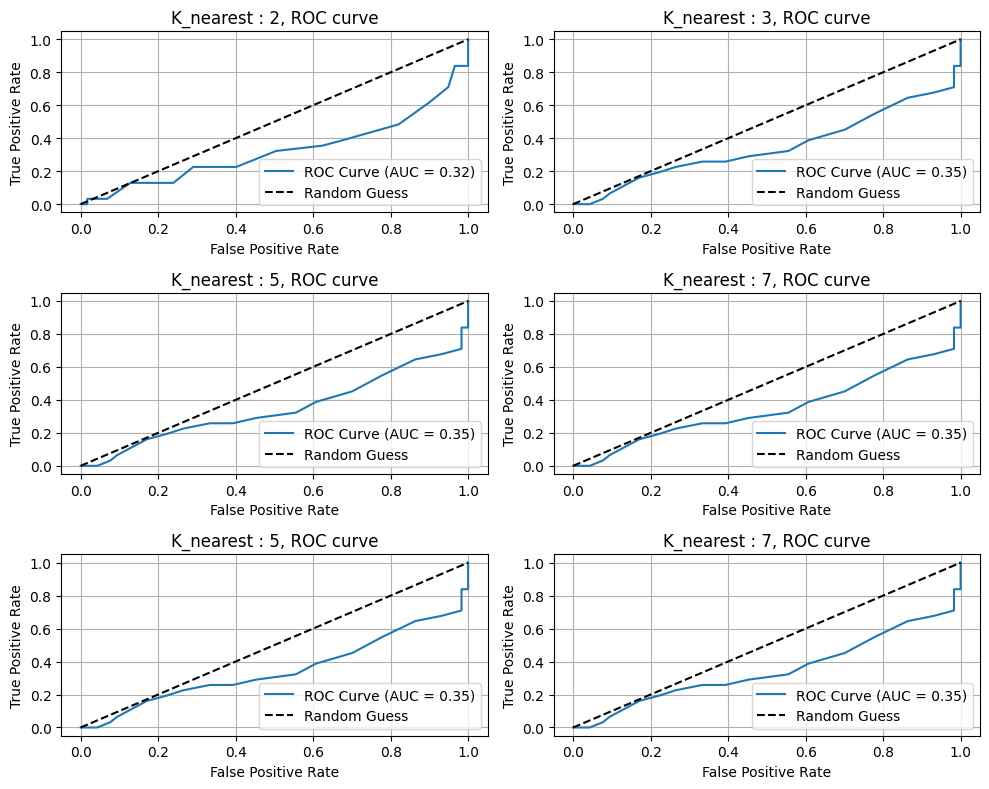

In [23]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(10)
fig.set_figheight(8)
plot_AUC_score(train_proba, test_proba, ax1, 2)
plot_AUC_score(train_proba_3, test_proba_3, ax2, 3)
plot_AUC_score(train_proba_5, test_proba_5, ax3, 5)
plot_AUC_score(train_proba_7, test_proba_7, ax4, 7)
plot_AUC_score(train_proba_10, test_proba_10, ax5, 5)
plot_AUC_score(train_proba_20, test_proba_20, ax6, 7)
fig.tight_layout()

# II) Window Based Techniques :

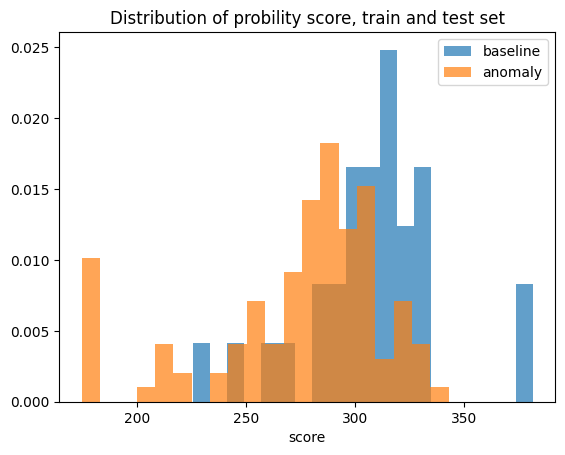

In [15]:
from WindowBased import Lookahead, NormalDictionary, UnsupervisedSVM

lookahead = Lookahead(window_length=10)
lookahead.train(baseline_train)

train_proba = lookahead.predict_proba(baseline_validation)
test_proba = lookahead.predict_proba(anomaly_sample)

plot_distribution(train_proba, test_proba)

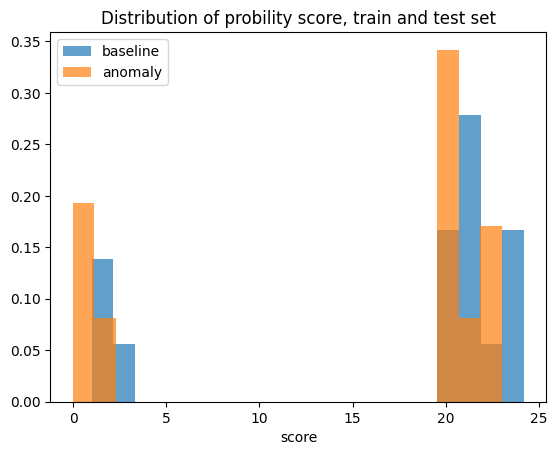

In [16]:
normal_dic = NormalDictionary(window_length=10)
normal_dic.train(baseline_train)

train_proba = normal_dic.predict_proba(baseline_validation)
test_proba = normal_dic.predict_proba(anomaly_sample)

plot_distribution(train_proba, test_proba)

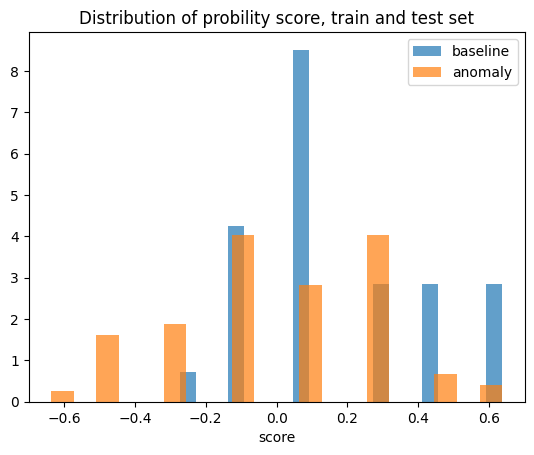

In [17]:
svm = UnsupervisedSVM(window_length=5)
svm.train(baseline_train)

train_proba = svm.predict_proba(baseline_validation)
test_proba = svm.predict_proba(anomaly_sample)

plot_distribution(train_proba, test_proba)

# IV) Markov Based Techniques : 

In [ ]:
from MarkovBased import FixedMarkovianBased, SparseMarkovRIPPER, SparseMarkovTransducer, VariableMarkovianBased

## Fixed Markov

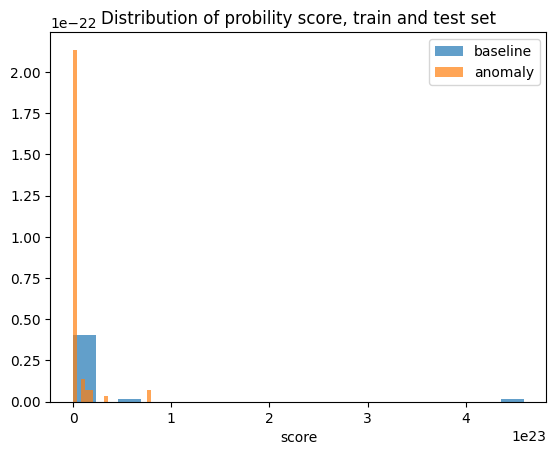

In [ ]:
fixed_markov = FixedMarkovianBased(max_depth=3)
fixed_markov.train(baseline_train)

train_proba = fixed_markov.predict_proba(baseline_validation)
test_proba = fixed_markov.predict_proba(anomaly_sample)
test_proba = [elt for elt in test_proba if elt != float("inf")]

plot_distribution(train_proba, test_proba)

## Variable Markov

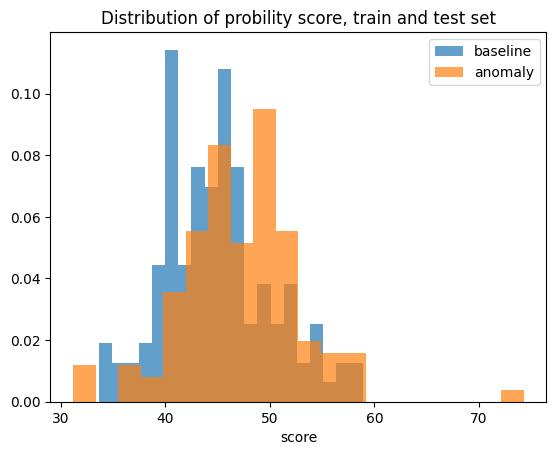

In [ ]:
variable_markov = VariableMarkovianBased(max_depth=10)
variable_markov.train(baseline_train)

train_proba = variable_markov.predict_proba(baseline_train)
test_proba = variable_markov.predict_proba(anomaly_sample)

plot_distribution(train_proba, test_proba)